# CIFAR100

#### Name: Ryan Ueda Teo Shao Ming
#### Admin No: 2122924
#### S/N: 06
#### Class: DAAA/FT/2B/05

In [1]:
from keras.datasets import cifar100
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras 
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.utils import plot_model
from keras.datasets import mnist
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.utils import load_img, img_to_array 
from keras.utils import image_utils
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import keras.callbacks
from keras.callbacks import Callback
from keras import initializers
from keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
import visualkeras

## Background Info On Dataset

CIFAR100 is a dataset consisting of 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

## Exporatory Data Analysis

In [2]:
## check number of rows and columns in dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

print("X Train -  rows:", X_train.shape[0]," columns:", X_train.shape[1])
print("X Test -  rows:", X_test.shape[0]," columns:", X_test.shape[1])

print("\nY Train -  rows:", y_train.shape[0])
print("Y Test -  rows:", y_test.shape[0])

X Train -  rows: 50000  columns: 32
X Test -  rows: 10000  columns: 32

Y Train -  rows: 50000
Y Test -  rows: 10000


<BarContainer object of 100 artists>

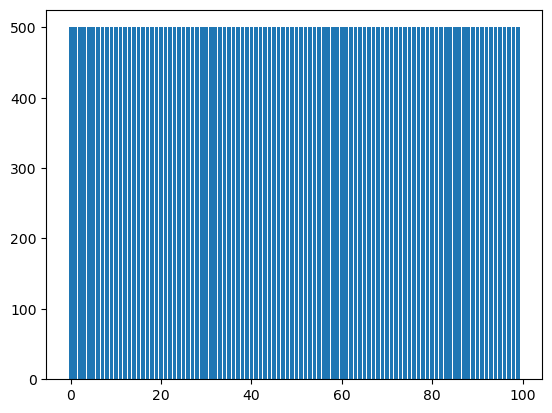

In [3]:
## check distribution of image samples per class
counts = np.array(np.unique(y_train, return_counts=True))
plt.bar(counts[0], counts[1])

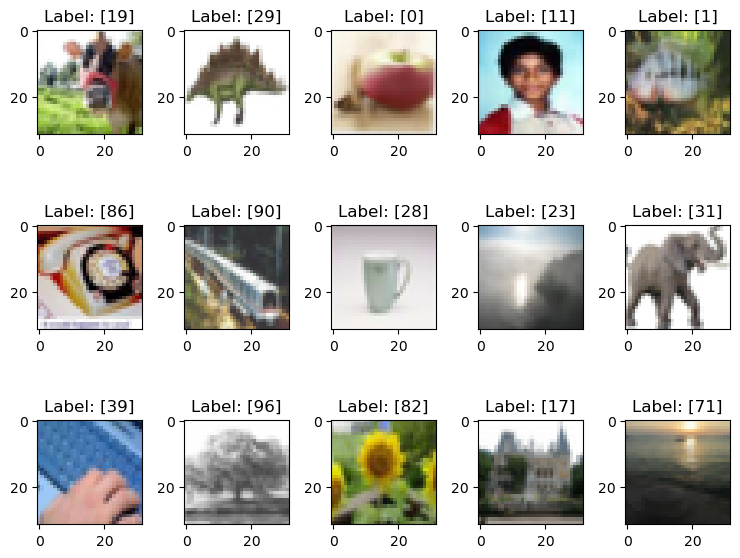

In [4]:
images = X_train[:15]
labels = y_train[:15]

## show a 3 X 5 grid sample of images
fig, axes = plt.subplots(3, 5, figsize=(1.5*5, 2*3))
for i in range(3*5):
    ax = axes[i//5, i%5]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Data Preprocessing

In [5]:
# Load CIFAR-100 data
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

## shuffle the data loaded to ensure there all data is random
indexes = np.arange(X_train.shape[0])
for _ in range(5): 
    indexes = np.random.permutation(indexes)  # shuffle 5 times
    X_train = X_train[indexes]
    y_train = y_train[indexes]
    

## split train set into train and validation sets: 12000 for validation, 38000 for train
X_val = X_train[:12000]
y_val = y_train[:12000]
X_train = X_train[12000:]
y_train = y_train[12000:]


# reshape to fit into CNN model
X_train = X_train.reshape(38000, 32, 32,3)
X_test = X_test.reshape(10000, 32, 32, 3)
X_val = X_val.reshape(12000, 32, 32, 3)


## parse as float + normalization (also allows data to train faster)
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

## encode target variables
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_val = to_categorical(y_val, 100)

In [6]:
## print shapes of train, test and valdiation data
print('X_train Shape: ' + str(X_train.shape))
print('y_train Shape: ' + str(y_train.shape))

print('\nX_test Shape: ' + str(X_test.shape))
print('y_test Shape: ' + str(y_test.shape))

print('\nX_val Shape: ' + str(X_val.shape))
print('y_val Shape: ' + str(y_val.shape))

X_train Shape: (38000, 32, 32, 3)
y_train Shape: (38000, 100)

X_test Shape: (10000, 32, 32, 3)
y_test Shape: (10000, 100)

X_val Shape: (12000, 32, 32, 3)
y_val Shape: (12000, 100)


## Model Architecture: Baseline Model

In [12]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(100, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

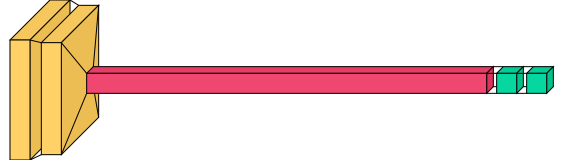

In [13]:
visualkeras.layered_view(model)

In [20]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               12845184  
                                                                 
 dense_7 (Dense)             (None, 100)               12900     
                                                                 
Total params: 12,933,732
Trainable params: 12,933,732
Non-trainable params: 0
_________________________________________________________________


In [21]:
## fit data to model
history = model.fit(X_train, y_train, batch_size=128, epochs=70, verbose=1, 
                    workers=-1, use_multiprocessing=True, 
                    validation_data=(X_val, y_val))

Epoch 1/70
297/297 [==============================] - 5s 15ms/step - loss: 3.9515 - accuracy: 0.1118 - val_loss: 3.3682 - val_accuracy: 0.2055
Epoch 2/70
297/297 [==============================] - 4s 13ms/step - loss: 3.0784 - accuracy: 0.2574 - val_loss: 3.0614 - val_accuracy: 0.2672
Epoch 3/70
297/297 [==============================] - 4s 14ms/step - loss: 2.5627 - accuracy: 0.3552 - val_loss: 2.9570 - val_accuracy: 0.2900
Epoch 4/70
297/297 [==============================] - 4s 13ms/step - loss: 2.0497 - accuracy: 0.4701 - val_loss: 3.0563 - val_accuracy: 0.2906
Epoch 5/70
297/297 [==============================] - 4s 13ms/step - loss: 1.4801 - accuracy: 0.6063 - val_loss: 3.3054 - val_accuracy: 0.2985
Epoch 6/70
297/297 [==============================] - 4s 13ms/step - loss: 0.9228 - accuracy: 0.7501 - val_loss: 3.8919 - val_accuracy: 0.2704
Epoch 7/70
297/297 [==============================] - 4s 13ms/step - loss: 0.4944 - accuracy: 0.8666 - val_loss: 4.5166 - val_accuracy: 0.2652

Epoch 58/70
297/297 [==============================] - 4s 13ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 14.5018 - val_accuracy: 0.2254
Epoch 59/70
297/297 [==============================] - 4s 13ms/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 14.6274 - val_accuracy: 0.2268
Epoch 60/70
297/297 [==============================] - 4s 13ms/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 14.4432 - val_accuracy: 0.2300
Epoch 61/70
297/297 [==============================] - 4s 13ms/step - loss: 0.0152 - accuracy: 0.9953 - val_loss: 14.2782 - val_accuracy: 0.2292
Epoch 62/70
297/297 [==============================] - 4s 13ms/step - loss: 0.0283 - accuracy: 0.9921 - val_loss: 14.3435 - val_accuracy: 0.2225
Epoch 63/70
297/297 [==============================] - 4s 13ms/step - loss: 0.0319 - accuracy: 0.9904 - val_loss: 14.6182 - val_accuracy: 0.2304
Epoch 64/70
297/297 [==============================] - 4s 13ms/step - loss: 0.0230 - accuracy: 0.9933 - val_loss: 14.2645 - val_ac

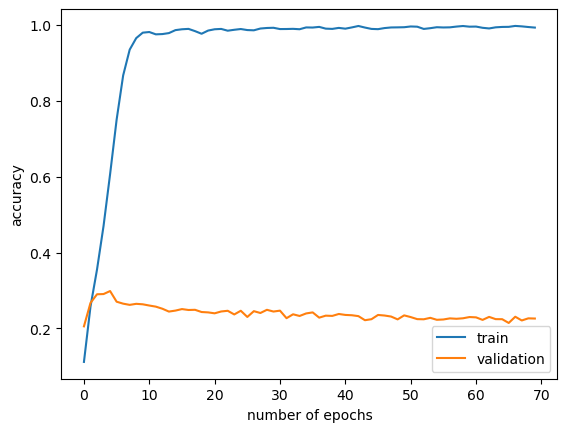

In [22]:
## plot valdiation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

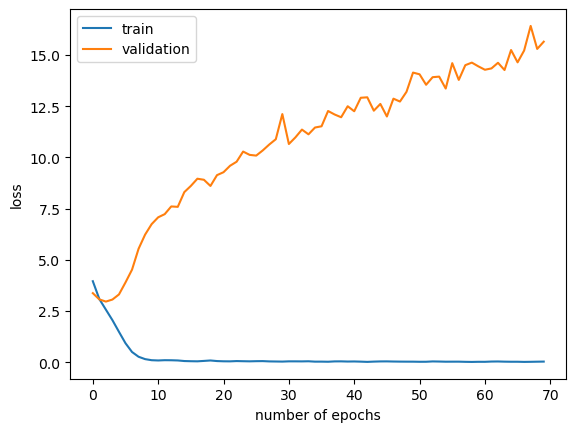

In [23]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

## Model Architechture: Model 2

In [2]:
l2 = regularizers.L2(0.05)
heUni = initializers.HeUniform(seed=24)

model = Sequential()


model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_regularizer=l2))
model.add(Dropout(rate=0.3))
model.add(Dense(256, activation='relu', kernel_regularizer=l2))
model.add(Dropout(rate=0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=l2))
model.add(Dense(100, activation='softmax'))

from keras.optimizers import SGD
sgd = SGD(learning_rate=0.1)
adam = Adam(learning_rate=0.004)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

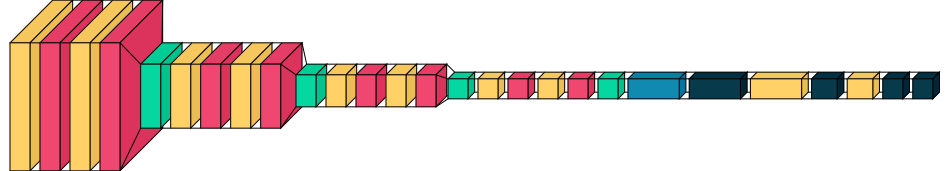

In [15]:
visualkeras.layered_view(model)

In [29]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

In [30]:
## fit data to model
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, 
                    workers=-1, use_multiprocessing=True, 
                    validation_data=(X_val, y_val))

Epoch 1/50
297/297 [==============================] - 8s 25ms/step - loss: 5.8860 - accuracy: 0.0197 - val_loss: 4.3683 - val_accuracy: 0.0280
Epoch 2/50
297/297 [==============================] - 7s 22ms/step - loss: 4.3247 - accuracy: 0.0305 - val_loss: 4.3741 - val_accuracy: 0.0269
Epoch 3/50
297/297 [==============================] - 7s 23ms/step - loss: 4.2406 - accuracy: 0.0355 - val_loss: 4.7010 - val_accuracy: 0.0301
Epoch 4/50
297/297 [==============================] - 7s 23ms/step - loss: 4.1782 - accuracy: 0.0391 - val_loss: 4.4261 - val_accuracy: 0.0344
Epoch 5/50
297/297 [==============================] - 7s 23ms/step - loss: 4.1009 - accuracy: 0.0456 - val_loss: 4.1873 - val_accuracy: 0.0421
Epoch 6/50
297/297 [==============================] - 7s 22ms/step - loss: 4.0193 - accuracy: 0.0557 - val_loss: 4.0124 - val_accuracy: 0.0607
Epoch 7/50
297/297 [==============================] - 7s 23ms/step - loss: 3.9469 - accuracy: 0.0626 - val_loss: 4.0529 - val_accuracy: 0.0637

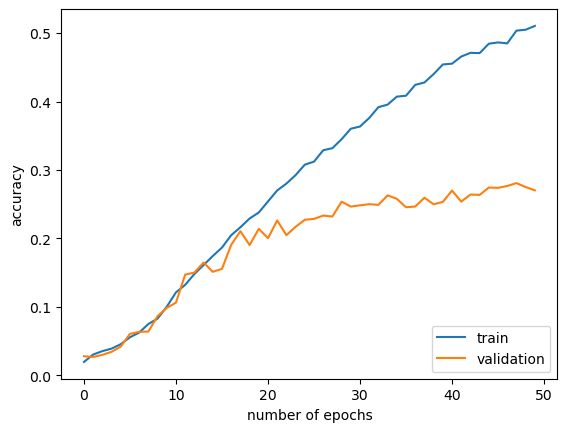

In [31]:
## plot valdiation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

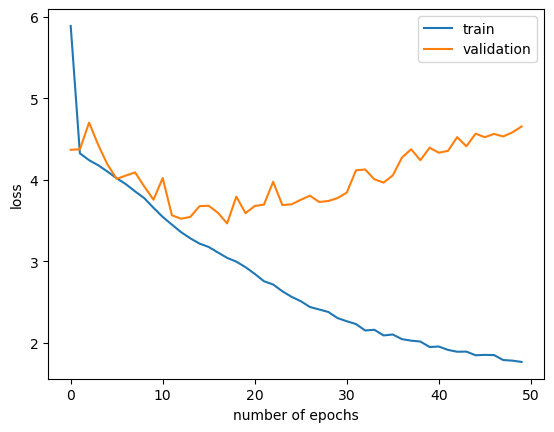

In [32]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

## Data Augmentation

### Image Data Generator

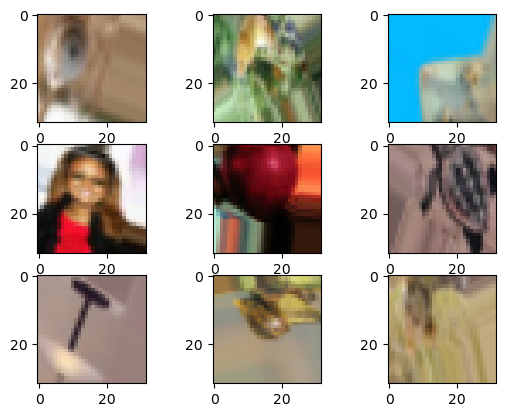

In [7]:
## image data gen
datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.3,
                             width_shift_range=0.3, height_shift_range=0.3,
                             horizontal_flip=True, vertical_flip=True)

## fit X_train 
datagen.fit(X_train)

## generate 12000 images and show 9 samples
for X_train_aug, y_train_aug in datagen.flow(X_train, y_train, batch_size=12000):
    ## 3 X 3 grid of images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_train_aug[i].reshape(32, 32, 3))

    ## show samples
    plt.show()
    break;

In [8]:
## concatenate images (X_train_aug, y_train_aug) generated to X_train, y_train
X_train = np.vstack((X_train, X_train_aug))
y_train = np.concatenate((y_train, y_train_aug))

print('X_train Shape: ' + str(X_train.shape))
print('y_train Shape: ' + str(y_train.shape))

X_train Shape: (50000, 32, 32, 3)
y_train Shape: (50000, 100)


In [ ]:
l2 = regularizers.L2(0.2)
l2Conv = regularizers.L2(0.01)
l2Out = regularizers.L2(0.008)
heUni = initializers.HeUniform(seed=24)

model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))
model.add(Dropout(rate=0.4))
model.add(Dense(100, activation='softmax', kernel_regularizer=l2Out))


from keras.optimizers import SGD
sgd = SGD(learning_rate=0.003)
adam = Adam(learning_rate=0.002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## compile the model
earlyStop = EarlyStopping(monitor='val_accuracy', patience=7)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=5, verbose=1, min_lr=0.00001)

## fit data to model
history = model.fit(train_ds_mu, batch_size=256, epochs=50, verbose=1, 
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc, earlyStop], 
                    validation_data=(val_ds))

In [ ]:
## plot valdiation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

In [ ]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

### Mix Up Data Augmentation

In [8]:
## Mix Up 
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    ## unpack datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    ## sample beta and reshape data
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006729091517627239, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9932709336280823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9997179508209229, 0.0002820735680870712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

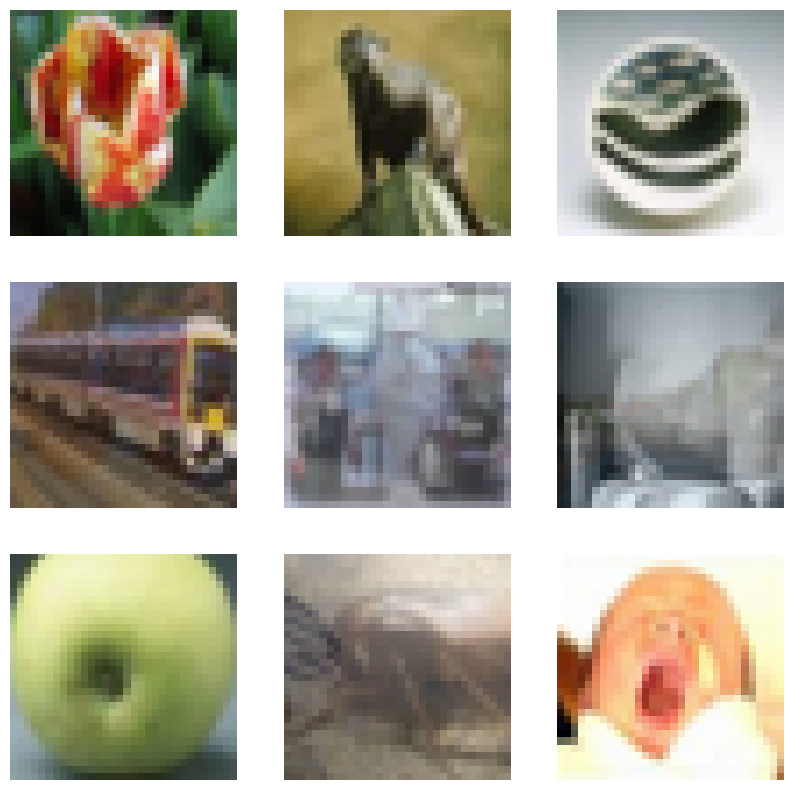

In [9]:
## create new dataset
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

## show 9 samples
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [10]:
l2 = regularizers.L2(0.2)
l2Conv = regularizers.L2(0.01)
l2Out = regularizers.L2(0.008)
heUni = initializers.HeUniform(seed=24)

model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))
model.add(Dropout(rate=0.4))
model.add(Dense(100, activation='softmax', kernel_regularizer=l2Out))


from keras.optimizers import SGD
sgd = SGD(learning_rate=0.003)
adam = Adam(learning_rate=0.002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
## compile the model
earlyStop = EarlyStopping(monitor='val_accuracy', patience=7)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=5, verbose=1, min_lr=0.00001)

## fit data to model
history = model.fit(train_ds_mu, batch_size=256, epochs=50, verbose=1, 
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc, earlyStop], 
                    validation_data=(val_ds))

Epoch 1/50
594/594 [==============================] - 41s 59ms/step - loss: 19.4683 - accuracy: 0.0298 - val_loss: 7.1744 - val_accuracy: 0.0329 - lr: 0.0020
Epoch 2/50
594/594 [==============================] - 34s 56ms/step - loss: 6.3539 - accuracy: 0.0542 - val_loss: 5.8663 - val_accuracy: 0.0617 - lr: 0.0020
Epoch 3/50
594/594 [==============================] - 34s 56ms/step - loss: 5.7419 - accuracy: 0.0618 - val_loss: 5.5579 - val_accuracy: 0.0727 - lr: 0.0020
Epoch 4/50
594/594 [==============================] - 34s 57ms/step - loss: 5.6126 - accuracy: 0.0626 - val_loss: 5.5060 - val_accuracy: 0.0622 - lr: 0.0020
Epoch 5/50
594/594 [==============================] - 34s 57ms/step - loss: 5.5259 - accuracy: 0.0677 - val_loss: 5.5202 - val_accuracy: 0.0583 - lr: 0.0020
Epoch 6/50
594/594 [==============================] - 34s 57ms/step - loss: 5.4624 - accuracy: 0.0713 - val_loss: 5.2366 - val_accuracy: 0.0864 - lr: 0.0020
Epoch 7/50
594/594 [==============================] - 34s

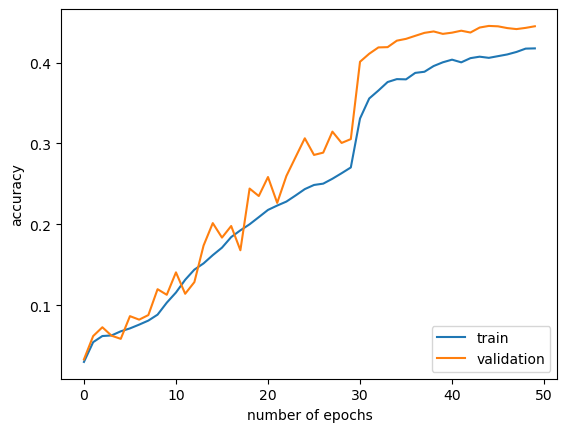

In [12]:
## plot valdiation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

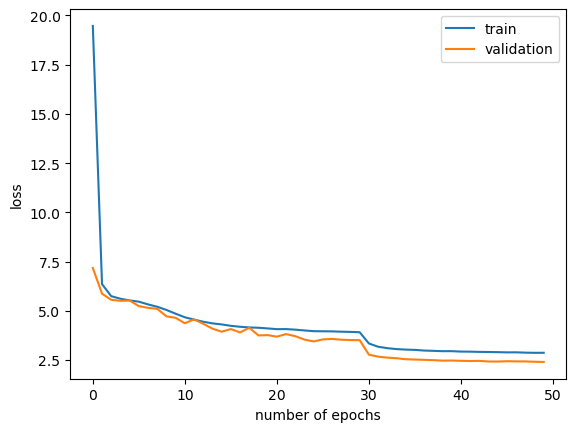

In [13]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

### Cut Mix Data Augmentation

In [16]:
## Cut Mix
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32
class_names = [
'apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel',
'can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile',
'cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard',
'lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom',
'oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum',
'rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel',
'streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle',
'wardrobe','whale','willow_tree','wolf','woman','worm',
]

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((X_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## combine shuffled datasets
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    val_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

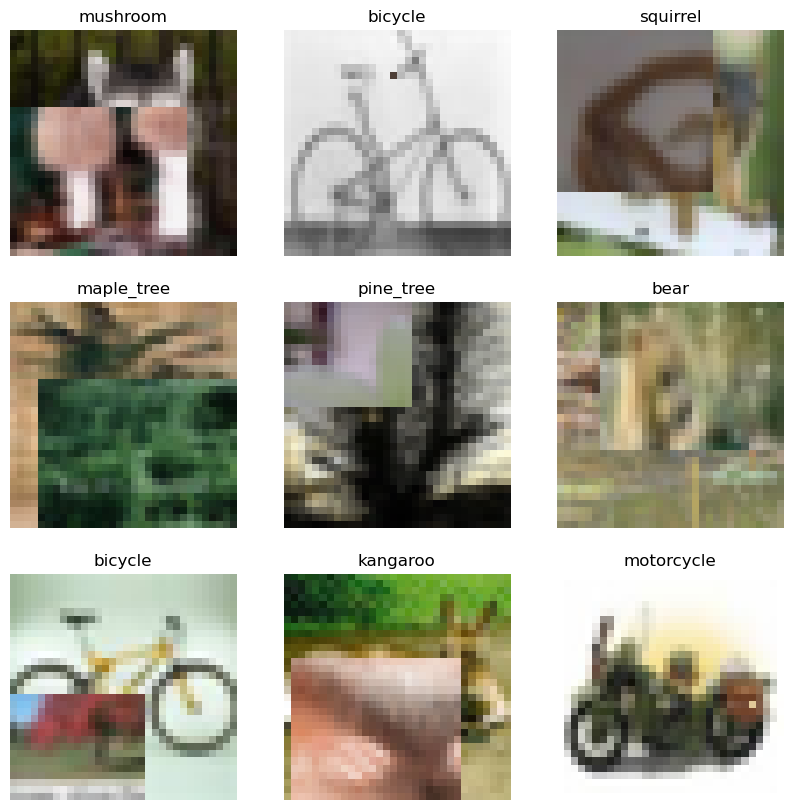

In [17]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    ## obtain sample from beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    ## define lambda
    lambda_value = lambda_value[0][0]

    ##get bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    ## get patch from image
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    ## pad image
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    ## get patch from iamge
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    ## pad image
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    ## modify image
    image1 = image1 - img1
    ## modified image --> cutmix image
    image = image1 + image2

    ## lambda value for pixel rotation
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    ## labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


## create new dataset
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## show 9 samples
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [18]:
l2 = regularizers.L2(0.2)
l2Conv = regularizers.L2(0.01)
l2Out = regularizers.L2(0.008)
heUni = initializers.HeUniform(seed=24)

model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))


model.add(Flatten())


model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))
model.add(Dropout(rate=0.4))
model.add(Dense(100, activation='softmax', kernel_regularizer=l2Out))


from keras.optimizers import SGD
sgd = SGD(learning_rate=0.003)
adam = Adam(learning_rate=0.002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
## compile the model
earlyStop = EarlyStopping(monitor='val_accuracy', patience=7)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=5, verbose=1, min_lr=0.00001)

## fit data to model
history = model.fit(train_ds_cmu, batch_size=256, epochs=50, verbose=1, 
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc, earlyStop], 
                    validation_data=(val_ds))

Epoch 1/50
1188/1188 [==============================] - 43s 35ms/step - loss: 14.4077 - accuracy: 0.0209 - val_loss: 5.7597 - val_accuracy: 0.0286 - lr: 0.0020
Epoch 2/50
1188/1188 [==============================] - 41s 34ms/step - loss: 5.2646 - accuracy: 0.0312 - val_loss: 4.9909 - val_accuracy: 0.0273 - lr: 0.0020
Epoch 3/50
1188/1188 [==============================] - 41s 34ms/step - loss: 4.9853 - accuracy: 0.0291 - val_loss: 5.0468 - val_accuracy: 0.0214 - lr: 0.0020
Epoch 4/50
1188/1188 [==============================] - 41s 34ms/step - loss: 4.9043 - accuracy: 0.0294 - val_loss: 4.8244 - val_accuracy: 0.0358 - lr: 0.0020
Epoch 5/50
1188/1188 [==============================] - 40s 34ms/step - loss: 4.8424 - accuracy: 0.0317 - val_loss: 4.6838 - val_accuracy: 0.0382 - lr: 0.0020
Epoch 6/50
1188/1188 [==============================] - 41s 34ms/step - loss: 4.7834 - accuracy: 0.0343 - val_loss: 4.6199 - val_accuracy: 0.0409 - lr: 0.0020
Epoch 7/50
1188/1188 [=======================

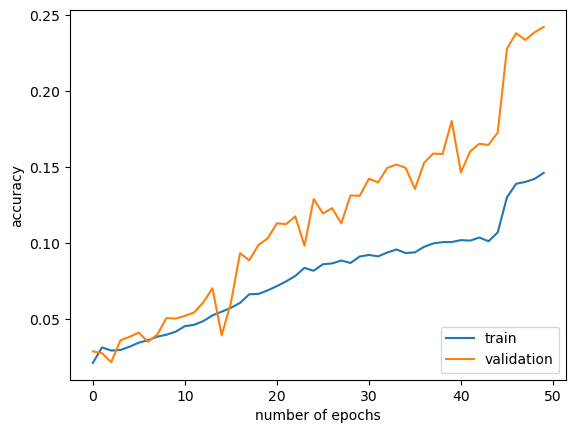

In [21]:
## plot valdiation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

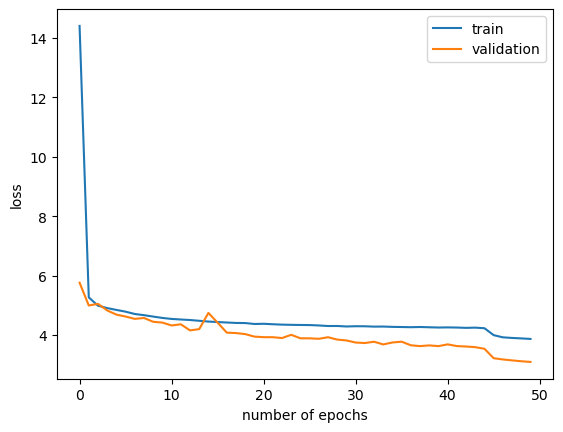

In [22]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

## Model Architecture: Model 3

In [16]:
## IMPROVING MODEL
l2 = regularizers.L2(0.2)
l2Conv = regularizers.L2(0.01)
l2Out = regularizers.L2(0.008)
heUni = initializers.HeUniform(seed=24)

model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))



model.add(Flatten())


model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))
model.add(Dropout(rate=0.4))
model.add(Dense(100, activation='softmax', kernel_regularizer=l2Out))


from keras.optimizers import SGD
sgd = SGD(learning_rate=0.003)
adam = Adam(learning_rate=0.002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

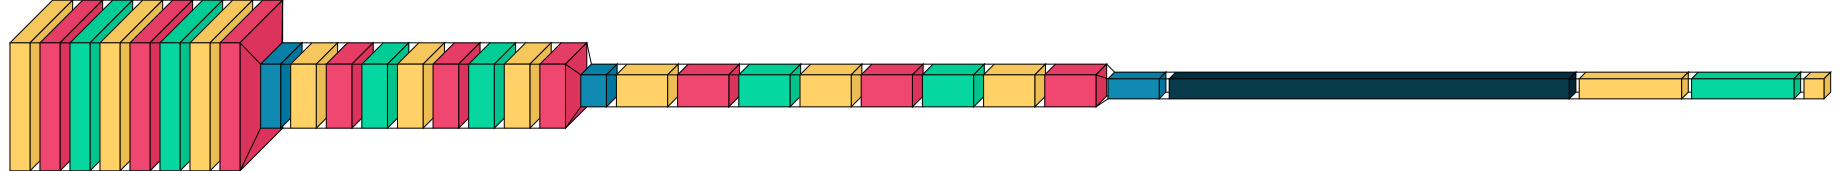

In [18]:
visualkeras.layered_view(model)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0

## Training The Model

In [19]:
## compile the model
earlyStop = EarlyStopping(monitor='val_accuracy', patience=5)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=4, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=4, verbose=1, min_lr=0.00001)

## fit data to model
history = model.fit(X_train, y_train, batch_size=256, epochs=45, verbose=1, 
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc, earlyStop], 
                    validation_data=(X_val, y_val))

Epoch 1/45
196/196 [==============================] - 38s 187ms/step - loss: 27.1163 - accuracy: 0.0411 - val_loss: 9.2857 - val_accuracy: 0.0288 - lr: 0.0020
Epoch 2/45
196/196 [==============================] - 36s 185ms/step - loss: 7.6454 - accuracy: 0.0709 - val_loss: 6.3541 - val_accuracy: 0.0591 - lr: 0.0020
Epoch 3/45
196/196 [==============================] - 36s 186ms/step - loss: 5.7303 - accuracy: 0.0908 - val_loss: 5.8739 - val_accuracy: 0.0745 - lr: 0.0020
Epoch 4/45
196/196 [==============================] - 36s 186ms/step - loss: 5.4925 - accuracy: 0.1115 - val_loss: 5.7934 - val_accuracy: 0.0935 - lr: 0.0020
Epoch 5/45
196/196 [==============================] - 36s 186ms/step - loss: 5.4240 - accuracy: 0.1313 - val_loss: 5.5256 - val_accuracy: 0.1176 - lr: 0.0020
Epoch 6/45
196/196 [==============================] - 36s 186ms/step - loss: 5.3789 - accuracy: 0.1473 - val_loss: 5.3908 - val_accuracy: 0.1573 - lr: 0.0020
Epoch 7/45
196/196 [==============================]

In [20]:
## evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: ' + str(score[1]))
print('Test Loss: ' + str(score[0]))

313/313 [==============================] - 3s 8ms/step - loss: 2.0005 - accuracy: 0.5888
Test Accuracy: 0.5888000130653381
Test Loss: 2.0004847049713135


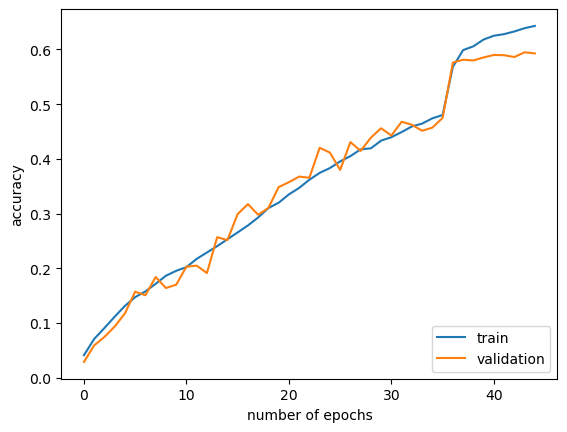

In [21]:
## plot valdiation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

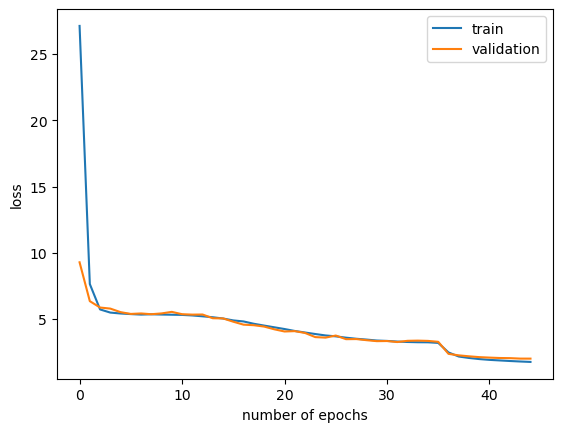

In [22]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

## ResNet Adaptation

In [19]:
def identity_block(x, filter):
    x_skip = x
    ## first layer
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    ## second layer
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    ## add residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    x_skip = x
    ## first layer
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    ## second layer
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    ## process residue
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    ## add residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 100):
    ## input layer
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    ## Conv layer with maxpooling
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    ## size of sub-blocks and filter
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    ## add blocks
    for i in range(4):
        if i == 0:
            ## sub-block 1: conv layer not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            ## Conv block --> Identity blocks
            ## filter size will increase by factors of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    ## end Dense layer
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    
    adam = Adam(learning_rate=0.002)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
model = ResNet34()

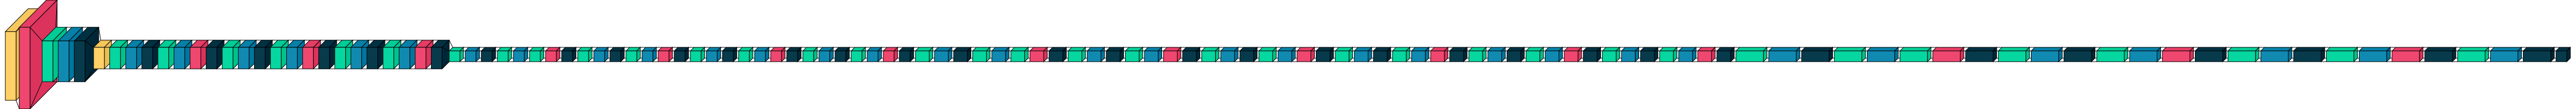

In [21]:
visualkeras.layered_view(model)

In [16]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 19, 19, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_33 (BatchN  (None, 19, 19, 64)  256         ['conv2d_36[0][0]']       

                                                                  'conv2d_45[0][0]']              
                                                                                                  
 activation_41 (Activation)     (None, 5, 5, 128)    0           ['add_19[0][0]']                 
                                                                                                  
 conv2d_46 (Conv2D)             (None, 5, 5, 128)    147584      ['activation_41[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 5, 5, 128)   512         ['conv2d_46[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_42 (Activation)     (None, 5, 5, 128)    0           ['batch_normalization_42[0][0]'] 
          

 batch_normalization_51 (BatchN  (None, 3, 3, 256)   1024        ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_24 (Add)                   (None, 3, 3, 256)    0           ['batch_normalization_51[0][0]', 
                                                                  'activation_49[0][0]']          
                                                                                                  
 activation_51 (Activation)     (None, 3, 3, 256)    0           ['add_24[0][0]']                 
                                                                                                  
 conv2d_57 (Conv2D)             (None, 3, 3, 256)    590080      ['activation_51[0][0]']          
                                                                                                  
 batch_nor

 conv2d_66 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_60[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_67 (Conv2D)             (None, 2, 2, 512)    131584      ['activation_59[0][0]']          
                                                                                                  
 add_29 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_61[0][0]', 
                                                                  'conv2d_67[0][0]']              
                                                                                                  
 activatio

In [17]:
## compile the model
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=8, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=8, verbose=1, min_lr=0.00001)

## fit data to model
history = model.fit(X_train, y_train, batch_size=256, epochs=70, verbose=1, 
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc], 
                    validation_data=(X_val, y_val))

Epoch 1/70
196/196 [==============================] - 20s 61ms/step - loss: 4.4478 - accuracy: 0.0303 - val_loss: 6.9349 - val_accuracy: 0.0283 - lr: 0.0020
Epoch 2/70
196/196 [==============================] - 11s 56ms/step - loss: 3.9610 - accuracy: 0.0735 - val_loss: 4.6128 - val_accuracy: 0.0588 - lr: 0.0020
Epoch 3/70
196/196 [==============================] - 11s 57ms/step - loss: 3.7251 - accuracy: 0.1103 - val_loss: 3.9890 - val_accuracy: 0.0938 - lr: 0.0020
Epoch 4/70
196/196 [==============================] - 11s 57ms/step - loss: 3.5072 - accuracy: 0.1493 - val_loss: 3.7585 - val_accuracy: 0.1482 - lr: 0.0020
Epoch 5/70
196/196 [==============================] - 11s 57ms/step - loss: 3.2930 - accuracy: 0.1884 - val_loss: 4.1608 - val_accuracy: 0.1371 - lr: 0.0020
Epoch 6/70
196/196 [==============================] - 11s 57ms/step - loss: 3.1173 - accuracy: 0.2203 - val_loss: 3.0834 - val_accuracy: 0.2383 - lr: 0.0020
Epoch 7/70
196/196 [==============================] - 11s 

In [18]:
## evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: ' + str(score[1]))
print('Test Loss: ' + str(score[0]))

313/313 [==============================] - 3s 10ms/step - loss: 7.3209 - accuracy: 0.3803
Test Accuracy: 0.38029998540878296
Test Loss: 7.320914268493652


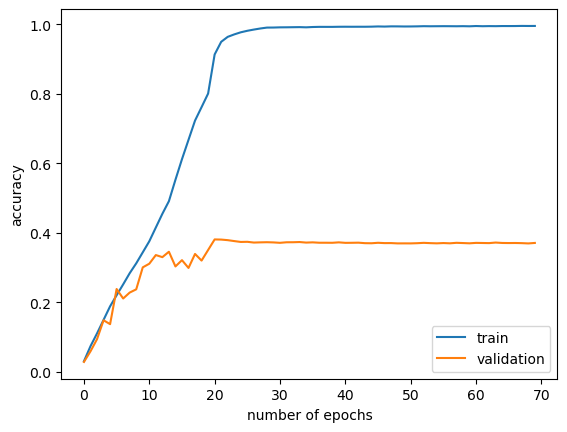

In [19]:
## plot validation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

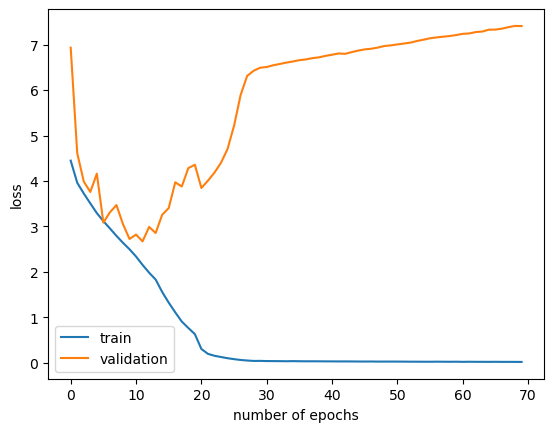

In [20]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

## Hyperparameter Tuning

In [23]:
def build_model(hp):
    hp_act = hp.Choice('activation', values=['relu', 'leaky_relu', 'sigmoid'])
    hp_init = hp.Choice('bias_initializer', values=['HeUniform', 'HeNormal', 'GlorotUniform', 'GlorotNormal'])
    hp_rate = hp.Choice('rate', values=[0.2, 0.3, 0.4])
    hp_lr = hp.Choice('learning_rate', values=[0.001, 0.002, 0.003])
    hp_opt = hp.Choice('optimizer', values=['adam', 'sgd'])

    l2 = regularizers.L2(0.2)
    l2Conv = regularizers.L2(0.01)
    l2Out = regularizers.L2(0.008)
    
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(hp_rate))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_rate))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same', kernel_regularizer=l2Conv))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_rate))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_rate))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same', kernel_regularizer=l2Conv))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_rate))
    model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_rate))
    model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same', kernel_regularizer=l2Conv))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(1024, activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, kernel_regularizer=l2))
    model.add(Dropout(rate=0.4))
    model.add(Dense(100, activation='softmax', kernel_regularizer=l2Out))


    from keras.optimizers import SGD
    sgd = SGD(learning_rate=0.003)
    adam = Adam(learning_rate=hp_lr)
    model.compile(optimizer=hp_opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [33]:
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=60, factor=3, directory='cifar_ht_2', project_name='test')
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), steps_per_epoch=128, workers=-1, use_multiprocessing=True, verbose=1)
best_hp=tuner.get_best_hyperparameters()[0]

INFO:tensorflow:Reloading Oracle from existing project cifar_ht_2\test\oracle.json
INFO:tensorflow:Reloading Tuner from cifar_ht_2\test\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [34]:
best_hp.values

{'activation': 'sigmoid',
 'bias_initializer': 'HeNormal',
 'rate': 0.4,
 'learning_rate': 0.003,
 'optimizer': 'adam',
 'tuner/epochs': 60,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [9]:
## hypertuned model
l2 = regularizers.L2(0.2)
l2Conv = regularizers.L2(0.01)
l2Out = regularizers.L2(0.008)
heUni = initializers.HeUniform(seed=24)
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='sigmoid', kernel_initializer='HeNormal', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))



model.add(Flatten())


model.add(Dense(1024, activation='sigmoid', kernel_initializer='HeNormal', bias_initializer='HeNormal', kernel_regularizer=l2))
model.add(Dropout(rate=0.4))
model.add(Dense(100, activation='softmax', kernel_regularizer=l2Out))


from keras.optimizers import SGD
sgd = SGD(learning_rate=0.003)
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
## compile the model
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=3, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=3, verbose=1, min_lr=0.00001)

## fit data to model
history = model.fit(X_train, y_train, batch_size=256, epochs=70, verbose=1, 
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc], 
                    validation_data=(X_val, y_val))

Epoch 1/70
196/196 [==============================] - 40s 199ms/step - loss: 26.0597 - accuracy: 0.0467 - val_loss: 5.5946 - val_accuracy: 0.0110 - lr: 0.0010
Epoch 2/70
196/196 [==============================] - 39s 198ms/step - loss: 4.6918 - accuracy: 0.0730 - val_loss: 5.1955 - val_accuracy: 0.0356 - lr: 0.0010
Epoch 3/70
196/196 [==============================] - 39s 198ms/step - loss: 4.4835 - accuracy: 0.0830 - val_loss: 4.7534 - val_accuracy: 0.0565 - lr: 0.0010
Epoch 4/70
196/196 [==============================] - 39s 198ms/step - loss: 4.4387 - accuracy: 0.0956 - val_loss: 4.4702 - val_accuracy: 0.0899 - lr: 0.0010
Epoch 5/70
196/196 [==============================] - 39s 198ms/step - loss: 4.4098 - accuracy: 0.1036 - val_loss: 4.5381 - val_accuracy: 0.0925 - lr: 0.0010
Epoch 6/70
196/196 [==============================] - 39s 198ms/step - loss: 4.4033 - accuracy: 0.1103 - val_loss: 4.5459 - val_accuracy: 0.0859 - lr: 0.0010
Epoch 7/70
196/196 [==============================]

In [11]:
## evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: ' + str(score[1]))
print('Test Loss: ' + str(score[0]))

313/313 [==============================] - 3s 10ms/step - loss: 3.0220 - accuracy: 0.3368
Test Accuracy: 0.3368000090122223
Test Loss: 3.022036552429199


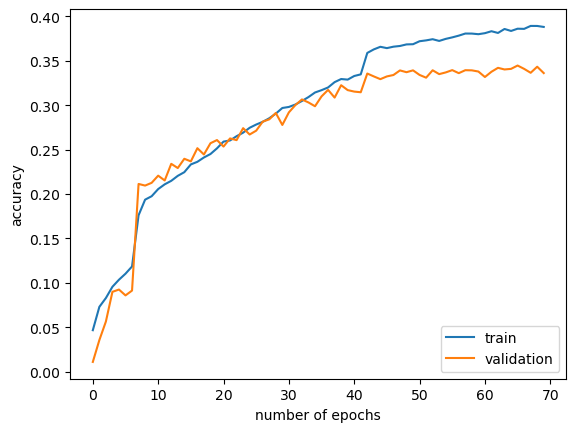

In [12]:
## plot valdiation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

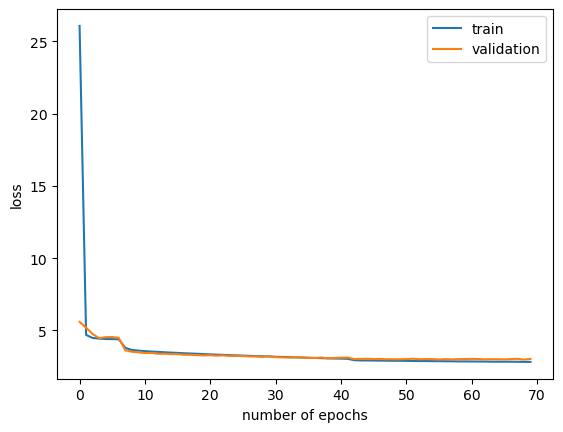

In [13]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

## graph shows model is overfitting

## Final Model

In [10]:
## Hypertuned model
l2 = regularizers.L2(0.2)
l2Conv = regularizers.L2(0.01)
l2Out = regularizers.L2(0.008)
heUni = initializers.HeUniform(seed=24)
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer='HeNormal', padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='HeNormal', bias_initializer=heUni, padding='same', kernel_regularizer=l2Conv))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))



model.add(Flatten())


model.add(Dense(1024, activation='relu', kernel_initializer='HeNormal', bias_initializer='HeNormal', kernel_regularizer=l2))
model.add(Dropout(rate=0.4))
model.add(Dense(100, activation='softmax', kernel_regularizer=l2Out))


from keras.optimizers import SGD
sgd = SGD(learning_rate=0.003)
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
## compile the model
earlyStop = EarlyStopping(monitor='val_accuracy', patience=8)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=5, verbose=1, min_lr=0.00001)

## fit data to model
history = model.fit(X_train, y_train, batch_size=255, epochs=55, verbose=1, 
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc], 
                    validation_data=(X_val, y_val))

Epoch 1/55
197/197 [==============================] - 45s 191ms/step - loss: 35.9984 - accuracy: 0.0462 - val_loss: 8.1442 - val_accuracy: 0.0158 - lr: 0.0010
Epoch 2/55
197/197 [==============================] - 37s 188ms/step - loss: 6.5786 - accuracy: 0.0904 - val_loss: 6.7305 - val_accuracy: 0.0164 - lr: 0.0010
Epoch 3/55
197/197 [==============================] - 37s 188ms/step - loss: 5.3535 - accuracy: 0.1186 - val_loss: 5.3234 - val_accuracy: 0.1067 - lr: 0.0010
Epoch 4/55
197/197 [==============================] - 37s 189ms/step - loss: 5.0234 - accuracy: 0.1452 - val_loss: 5.1229 - val_accuracy: 0.1262 - lr: 0.0010
Epoch 5/55
197/197 [==============================] - 37s 189ms/step - loss: 4.8855 - accuracy: 0.1708 - val_loss: 5.1643 - val_accuracy: 0.1256 - lr: 0.0010
Epoch 6/55
197/197 [==============================] - 37s 187ms/step - loss: 4.8286 - accuracy: 0.1949 - val_loss: 5.0104 - val_accuracy: 0.1679 - lr: 0.0010
Epoch 7/55
197/197 [==============================]

In [12]:
## evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: ' + str(score[1]))
print('Test Loss: ' + str(score[0]))

313/313 [==============================] - 3s 8ms/step - loss: 2.0800 - accuracy: 0.6338
Test Accuracy: 0.6338000297546387
Test Loss: 2.080000162124634


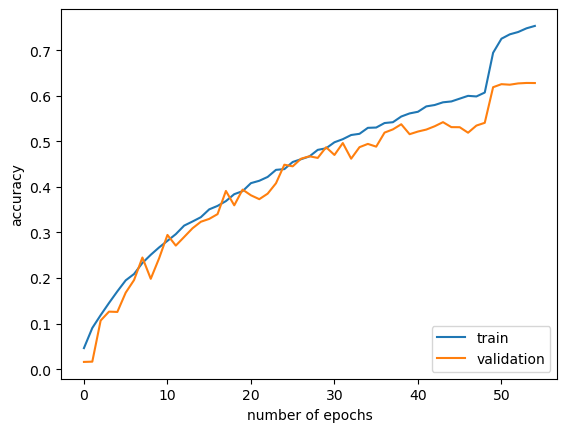

In [13]:
## plot valdiation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

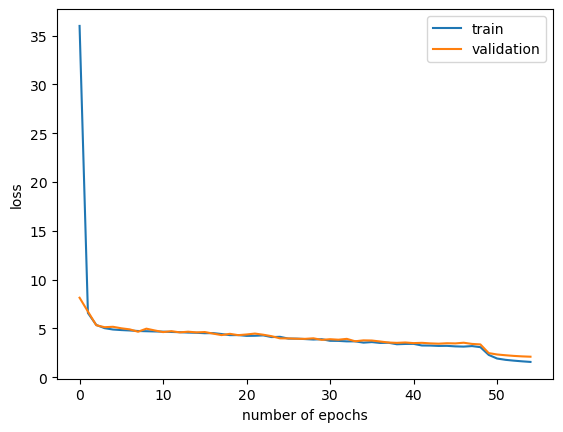

In [14]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='best')
plt.show()

## REFERENCES
##### https://keras.io/api/datasets/cifar100/   (dataset)
##### https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-convnet-for-cifar-10-and-cifar-100-classification-with-keras.md
##### https://www.kaggle.com/code/rosianebritodelima/cifar-100-with-cnn-and-transfer-learning/notebook
##### https://towardsdatascience.com/cifar-100-pre-processing-for-image-recognition-task-68015b43d658